## BoilerPlate command

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Importing Fast AI library

Let’s import fastai library and define our batch_size parameter to 64. Usually, image databases are enormous, so we need to feed these images into a GPU using batches, batch size 16428 means that we will feed 64 images at once to update parameters of our deep learning model. If you are running out of memory because of smaller GPU RAM, you can reduce batch size to 32 or 16.

In [2]:
from fastai.vision.all import *
from shallownet import *
from jupyterthemes import jtplot
jtplot.style(theme="monokai", context='notebook', ticks=True, grid=False)
bs=256

## Downloading Dataset

In [4]:
path = untar_data(URLs.CIFAR, dest="../data/");
path

Path('../data/cifar10')

In [5]:
path.ls()

(#3) [Path('../data/cifar10/labels.txt'),Path('../data/cifar10/test'),Path('../data/cifar10/train')]

In [6]:
(path/'train').ls()

(#10) [Path('../data/cifar10/train/airplane'),Path('../data/cifar10/train/automobile'),Path('../data/cifar10/train/bird'),Path('../data/cifar10/train/cat'),Path('../data/cifar10/train/deer'),Path('../data/cifar10/train/dog'),Path('../data/cifar10/train/frog'),Path('../data/cifar10/train/horse'),Path('../data/cifar10/train/ship'),Path('../data/cifar10/train/truck')]

Within each digit folder, we have images.

In [7]:
(path/'train/airplane').ls()[1:5]

(#4) [Path('../data/cifar10/train/airplane/10010_airplane.png'),Path('../data/cifar10/train/airplane/10020_airplane.png'),Path('../data/cifar10/train/airplane/10024_airplane.png'),Path('../data/cifar10/train/airplane/10031_airplane.png')]

## Importing Data

In [8]:
cifar = DataBlock(blocks=(ImageBlock(), CategoryBlock), 
                  get_items=get_image_files, 
                  #splitter=RandomSplitter(0.2),
                  splitter=GrandparentSplitter(train_name='train', valid_name='test'),
                  get_y=parent_label,
                  item_tfms=Resize(32),
                  batch_tfms=None)
dls = cifar.dataloaders(path, bs=bs)

In [9]:
dls.train_ds

(#50000) [(PILImage mode=RGB size=32x32, TensorCategory(0)),(PILImage mode=RGB size=32x32, TensorCategory(0)),(PILImage mode=RGB size=32x32, TensorCategory(0)),(PILImage mode=RGB size=32x32, TensorCategory(0)),(PILImage mode=RGB size=32x32, TensorCategory(0)),(PILImage mode=RGB size=32x32, TensorCategory(0)),(PILImage mode=RGB size=32x32, TensorCategory(0)),(PILImage mode=RGB size=32x32, TensorCategory(0)),(PILImage mode=RGB size=32x32, TensorCategory(0)),(PILImage mode=RGB size=32x32, TensorCategory(0))...]

In [11]:
dls.valid_ds

(#10000) [(PILImage mode=RGB size=32x32, TensorCategory(0)),(PILImage mode=RGB size=32x32, TensorCategory(0)),(PILImage mode=RGB size=32x32, TensorCategory(0)),(PILImage mode=RGB size=32x32, TensorCategory(0)),(PILImage mode=RGB size=32x32, TensorCategory(0)),(PILImage mode=RGB size=32x32, TensorCategory(0)),(PILImage mode=RGB size=32x32, TensorCategory(0)),(PILImage mode=RGB size=32x32, TensorCategory(0)),(PILImage mode=RGB size=32x32, TensorCategory(0)),(PILImage mode=RGB size=32x32, TensorCategory(0))...]

(#10) ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
10


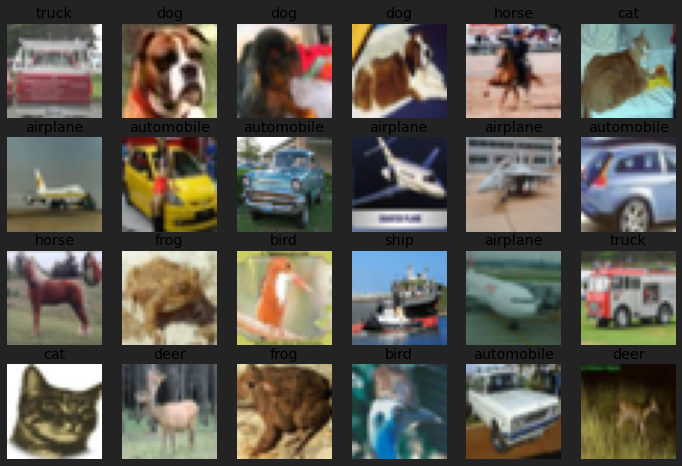

In [16]:
print(dls.vocab) ## Prints class labels
print(dls.c) ## Prints number of classes
dls.show_batch(max_n=24, figsize=(12,8)) ## Show sample data

## About the model

ShallowNet is just a dummy model which just implement the idea of basic convolutional network, with CONV=>RELU=>FC layer. it's not supposed to give ground breaking performance and is only built for practice purposes.

## Training the model

We have defined our shallownet model in shallownet.py file, now we need to train it. We can use FastAI's *Learner* function which makes it easier to leverage modern enhancement in optimization methods and many other neat tricks like  1-Cycle style training as highlighted in [Leslie Smith's paper](https://arxiv.org/pdf/1803.09820.pdf) for faster convergence. Let's define our Learner class -

In [18]:
## Defining the learner
sn_learner = Learner(
    dls=dls, 
    model=ShallowNet(n_class=dls.c, size=32, in_channels=3), 
    pretrained=False,
    loss_func=nn.CrossEntropyLoss(),
    model_dir=path/"models",
    metrics=accuracy
)

SuggestedLRs(lr_min=0.002290867641568184, lr_steep=0.3630780577659607)

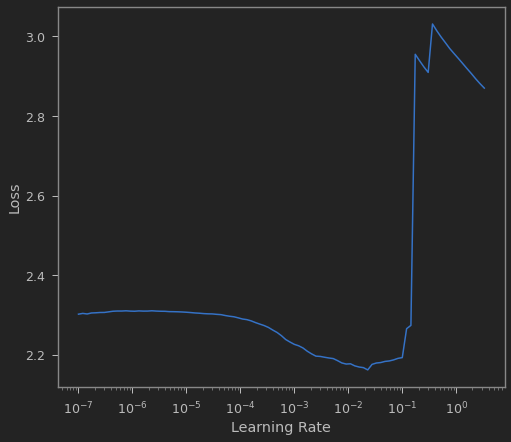

In [20]:
## Finidng Ideal learning late
sn_learner.lr_find()

In [21]:
sn_learner.fit_one_cycle(10,1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,1.546022,1.468535,0.480600,01:09
1,1.459037,1.522632,0.469200,01:05
2,1.399294,1.432277,0.490800,01:06
3,1.263759,1.437668,0.512900,01:08
4,1.163538,1.343770,0.543300,01:06
5,1.028517,1.282902,0.570700,01:03
6,0.880584,1.272411,0.579800,01:01
7,0.767553,1.264711,0.582000,01:03
8,0.675024,1.259294,0.589800,01:03
9,0.635888,1.265369,0.593500,01:02


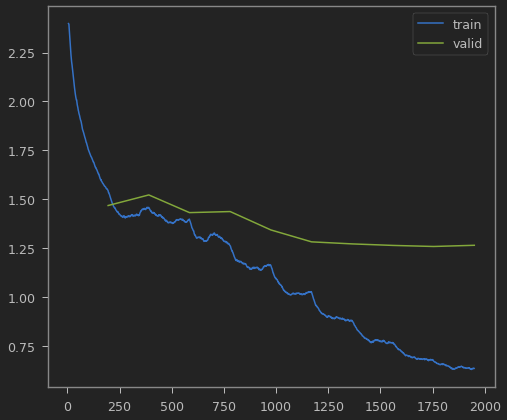

In [22]:
sn_learner.recorder.plot_loss()

In [24]:
from sklearn.metrics import classification_report
interp = ClassificationInterpretation.from_learner(sn_learner)
print(classification_report(np.array(interp.preds).argmax(axis=1), interp.targs))

              precision    recall  f1-score   support

           0       0.63      0.64      0.63       982
           1       0.69      0.70      0.70       992
           2       0.45      0.46      0.46       976
           3       0.40      0.42      0.41       953
           4       0.52      0.52      0.52       999
           5       0.49      0.50      0.49       973
           6       0.71      0.68      0.70      1051
           7       0.66      0.65      0.66      1019
           8       0.72      0.70      0.71      1024
           9       0.66      0.64      0.65      1031

    accuracy                           0.59     10000
   macro avg       0.59      0.59      0.59     10000
weighted avg       0.60      0.59      0.59     10000

